# Variational auto-encoder (VAE) with MNIST

In [1]:
import inferpy as inf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability.python.edward2 as ed
%matplotlib inline
# reset tensorflow
tf.reset_default_graph()
tf.set_random_seed(1234)

### Load MNIST data 

(60000, 28, 28) (60000,)
(3119, 28, 28)


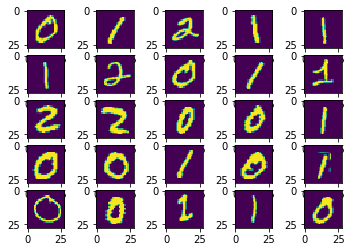

In [77]:
from tensorflow.keras.datasets import mnist

# number of observations (dataset size)
N = 10000

# digits considered
DIG = [0, 1, 2]
# load the data

(x_train, y_train), _ = mnist.load_data()

print(x_train.shape, y_train.shape)

x_train = x_train[:N]
y_train = y_train[:N]

idx = np.where(np.logical_or(np.logical_or(y_train == 0 ,y_train==1), y_train==2))

x_tr = x_train[idx]
y_tr = y_train[idx]

#np.save('X_mnist',x_train)
#np.save('Y_mnist',y_train)
print(x_tr.shape)

fig,axs = plt.subplots(5,5)
c = 0 
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(x_tr[c])
        c+=1

### Define neural networks for decoding and encoding

In [78]:
from tensorflow import keras

In [79]:
def decoder(z,d0,dx):
    h0 = keras.layers.Dense(d0, activation=tf.nn.relu) # K -> d0
    h1 = keras.layers.Dense(dx) # d0 -> dx (28*28)
    return h1(h0(z))

In [80]:
def encoder(x,d0,k):
    h0 = keras.layers.Dense(d0, activation=tf.nn.relu) # dx (28*28) -> d0
    h1 = keras.layers.Dense(2*k)
    return h1(h0(x))

### Define Generative probabilistic model 

In [81]:
@inf.probmodel
def vae(k, d0, dx, decoder):
    with inf.datamodel():
        z = inf.Normal(tf.zeros(k), 1., name="z") # hidden distribution
        x = inf.Normal(decoder(z, d0, dx), 1., name="x") # decode from hidden

### Define variational "Proxy" model

In [82]:
# Q model for making inference
@inf.probmodel
def qmodel(k, d0, dx, encoder, scale_epsilon = 1e-2):
    
    with inf.datamodel():
        
        x = inf.Normal(tf.ones(dx), 1, name='x') # N,dx(28*28)
        output = encoder(x,d0,k)
        
        qz_loc = output[:,:k]
        qz_scale = tf.nn.softplus(output[:,k:]) + scale_epsilon
        
        qz = inf.Normal(qz_loc, qz_scale, name='z')
        

### Init the models

In [83]:
# hidden dimensionality
k = 2
# size of the hidden layer in the NN
d0 = 100
# dimensionality of the data
dx = 28 * 28

m = vae(k, d0, dx, decoder)
q = qmodel(k, d0, dx, encoder)

### Define BB inference method

In [85]:
# inference parameters
num_epochs = 2000
lr = 0.01

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=lr)
# set the inference algorithm
VI = inf.inference.VI(q, epochs=2000, optimizer = opt)

### Fit the model

In [86]:
x_tr = x_tr.reshape((-1,28*28))
x_tr.shape
m.fit({'x': x_tr},VI)


 0 epochs	 14100118528.0....................
 200 epochs	 3067629568.0....................
 400 epochs	 2885630976.0....................
 600 epochs	 2832686080.0....................
 800 epochs	 2796390144.0....................
 1000 epochs	 2786599680.0....................
 1200 epochs	 2768341504.0....................
 1400 epochs	 2752659200.0....................
 1600 epochs	 2736784384.0....................
 1800 epochs	 2710559232.0....................

### Extract the posterior and generate new digits

In [87]:
x_tr.shape
postz = m.posterior("z", data={"x": x_tr}).parameters()['loc']
postz.shape

(3119, 2)

### Plot hidden distribution for the digits 

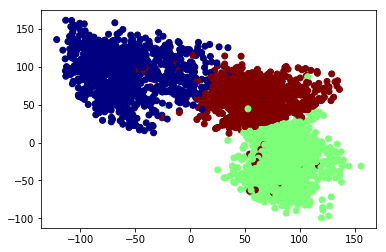

In [88]:
from matplotlib import cm
_=plt.scatter(*postz.T,c=y_tr,cmap=cm.jet)

### Generate new digits from the hidden distribution

In [89]:
x_gen = m.posterior_predictive('x', data={"z": postz}).sample()
x_gen.shape

(3119, 784)

### Plot the generated digits

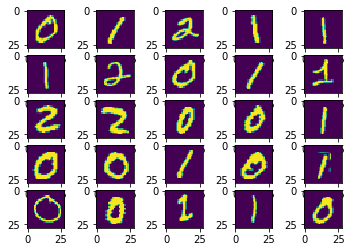

In [90]:
x_tr = x_tr.reshape((-1,28,28))
fig,axs = plt.subplots(5,5)
c = 0 
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(x_tr[c])
        c+=1

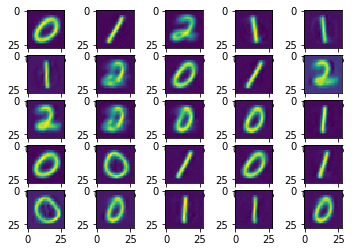

In [91]:
x_gen = x_gen.reshape((-1,28,28))
fig,axs = plt.subplots(5,5)
c = 0 
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(x_gen[c])
        c+=1

In [ ]:
#mnist.plot_digits(x_gen[:25], grid=[5,5])